In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker, cm
from math import sqrt, pi
from numpy import exp, cos, sin
from numpy.linalg import norm
import seaborn as sns
import time

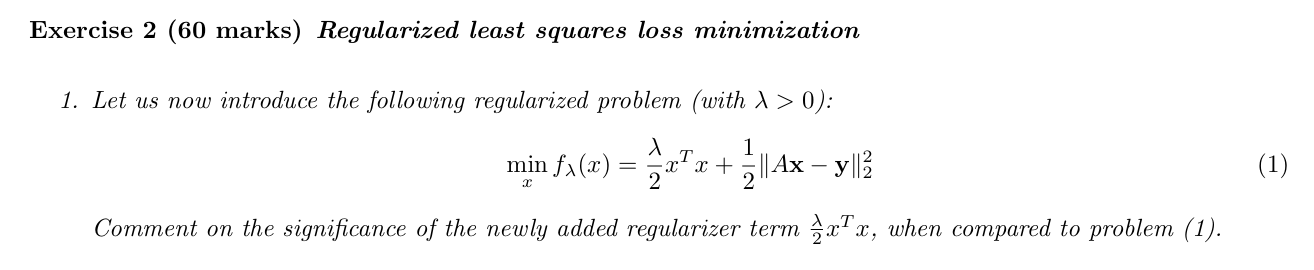

The addition of the regularizer term $\frac{\lambda}{2}x^Tx$ in a linear regression problem is significant as it introduces regularization to the model. Regularization is a technique used to prevent overfitting and improve the generalization ability of the model by penalizing overly complex models.

In linear regression, the typical problem aims to minimize the sum of squared errors between the predicted and actual values of the dependent variable. However, this may lead to overfitting, especially when the number of features (or dimensions) in the dataset is large relative to the number of observations. In such cases, the model may learn the noise in the training data, resulting in poor performance on unseen data.

By adding the regularizer term, the model is encouraged to choose simpler solutions by penalizing large coefficients in the feature vector x. The term λ controls the strength of regularization, with higher values of λ leading to more pronounced penalization of complex models.

Comparing to the problem without regularization, the addition of $\frac{\lambda}{2}x^Tx$ adjusts the optimization objective and makes the problem strictly convex and optimization is effective. This can lead to improved performance on unseen data and increased robustness of the model.

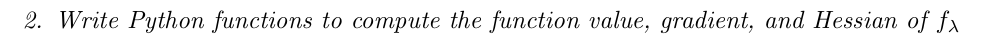

Note that $f(x) = \frac{1}{2}\|Ax-y\|_2^2 + \frac{\lambda}{2}x^Tx$

$⇒\nabla_x{f(x)} = A^TAx - A^Ty + \lambda x$

$\nabla_x^2{f(x)} = A^TA + \lambda I$

In [32]:
np.random.seed(1000)
A = []
for i in range(1000):
  row = []
  for j in range(10):
    row.append(np.random.randn())
  A.append(row)
A = np.array(A)

xbar = []
for i in range(1,11):
  if i%2 == 1 :
    xbar.append(np.random.uniform(-(i+1), -i))
  else:
    xbar.append(np.random.uniform(i, i+1))
xbar = np.array(xbar)

ep = np.array([np.random.randn() for i in range(1000)])

y = A@xbar + ep

In [33]:
def fx(x, lamda):
  return 0.5*norm(A@x-y)**2 + 0.5*lamda*np.dot(x,x)

def grad_fx(x, lamda):
  return np.dot(A.transpose(), A)@x - A.transpose()@y + lamda*x

def hessian_fx(lamda):
  return A.transpose()@A + lamda*np.identity(A.shape[1])


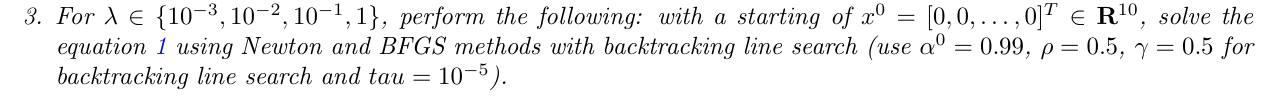

In [34]:
def dk_fx(lamda):
  return np.linalg.inv(hessian_fx(lamda))

def get_alpha_newton(xk, alpha0, rho, gamma, Dk, lamda):
  alpha = alpha0
  pk = -grad_fx(xk, lamda)
  while fx(xk + alpha*Dk@pk, lamda) > (fx(xk, lamda) + gamma*alpha*grad_fx(xk, lamda)@Dk@pk):
    alpha = rho*alpha
  return alpha

def newton_method_with_backtracking(x0, tau, alpha0, rho, gamma, lamda):
  xk = np.copy(x0)
  count = 0
  pk = grad_fx(xk, lamda)
  xks = []
  xks.append(xk)
  while norm(pk)>tau:
    Dk = dk_fx(lamda)
    alpha = get_alpha_newton(xk, alpha0, rho, gamma, Dk, lamda)
    xk = xk - alpha*Dk@pk
    pk = grad_fx(xk, lamda)
    xks.append(xk)
    count += 1
  return count, xk, fx(xk, lamda), xks

def get_alpha_bfgs(xk, alpha0, rho, gamma, Bk, lamda):
  alpha = alpha0
  pk = -grad_fx(xk, lamda)
  while fx(xk + alpha*Bk@pk, lamda) > (fx(xk, lamda) + gamma*alpha*grad_fx(xk, lamda)@Bk@pk):
    alpha = rho*alpha
  return alpha


def bfgs(x0, tau, alpha0, rho, gamma, lamda, max_iter=500):
  xk = np.copy(x0)
  n = len(x0)
  Bk = np.eye(n)
  count = 0
  pk = grad_fx(xk, lamda)
  xks = []
  xks.append(xk)
  while (norm(pk)>tau):
    if count > max_iter:
      break

    alpha = get_alpha_bfgs(xk, alpha0, rho, gamma, Bk, lamda)
    xnext = xk - alpha*(Bk@pk)

    # print("new xk: ", xk[0:5])
    ## new Bk+1 computation
    sk = xnext - xk
    yk = grad_fx(xnext, lamda) - grad_fx(xk, lamda)
    # BFGS update formula
    Bk = np.dot((np.eye(len(xk)) - np.outer(sk, yk) / np.dot(yk, sk)), np.dot(Bk, (np.eye(len(xk)) - np.outer(yk, sk) / np.dot(yk, sk)))) + np.outer(sk, sk) / np.dot(yk, sk)

    xk = xnext
    pk = grad_fx(xk, lamda)
    # print("grad is: ", pk[0:5])
    # print("grad norm is: ", norm(pk))
    xks.append(xk)
    count += 1

  return count, xk, fx(xk, lamda), xks


#initializations
x0 = np.array([0 for _ in range(10)])
tau = 1e-5
alpha0 = 0.99
rho = 0.5
gamma = 0.5


lambdaxksbfgs = []
lambdaxksnewton = []
iterationcountlambdabfgs = []
iterationcountlambdanewton = []
timetakenbfgs = []
timetakennewton = []


print("lamda|   iterations  | final minimizer    | final value       |type    ")
print("---------------------------------------------------------------------------")
lds = [0.001, 0.01, 0.1, 1]
for lamda in lds:
  start = time.time()
  count, minimizer, minimum, xks=bfgs(x0,tau, alpha0, rho, gamma, lamda)
  timetakenbfgs.append(time.time()- start)
  print(f"{lamda} |  {count}   |{minimizer}    |{minimum}     | bfgs")
  print("---------------------------------------------------------------------------")
  start = time.time()
  count2, final_xk2, final_val2, xks2= newton_method_with_backtracking(x0, tau, alpha0, rho, gamma, lamda)
  timetakennewton.append(time.time()- start)
  print(f"{lamda}  | {count2}   |{final_xk2}    |{final_val2}     | newton with backtracking")
  print("---------------------------------------------------------------------------")
  lambdaxksbfgs.append(xks)
  lambdaxksnewton.append(xks2)
  iterationcountlambdabfgs.append(count)
  iterationcountlambdanewton.append(count2)



lamda|   iterations  | final minimizer    | final value       |type    
---------------------------------------------------------------------------
0.001 |  18   |[-1.04982182  2.95189522 -3.34297873  4.6095547  -5.71175719  6.89876991
 -7.62878664  8.16820415 -9.22220401 10.05668398]    |505.86410991442835     | bfgs
---------------------------------------------------------------------------
0.001  | 5   |[-1.04982182  2.95189522 -3.34297873  4.6095547  -5.71175719  6.89876991
 -7.62878664  8.16820415 -9.22220401 10.05668398]    |505.8641099144283     | newton with backtracking
---------------------------------------------------------------------------
0.01 |  18   |[-1.04981537  2.95187528 -3.34295004  4.60950637 -5.71171441  6.89871349
 -7.62872413  8.16814145 -9.22213214 10.05660346]    |507.8151160259467     | bfgs
---------------------------------------------------------------------------
0.01  | 5   |[-1.04981537  2.95187528 -3.34295004  4.60950637 -5.71171441  6.8987135
 -7.628

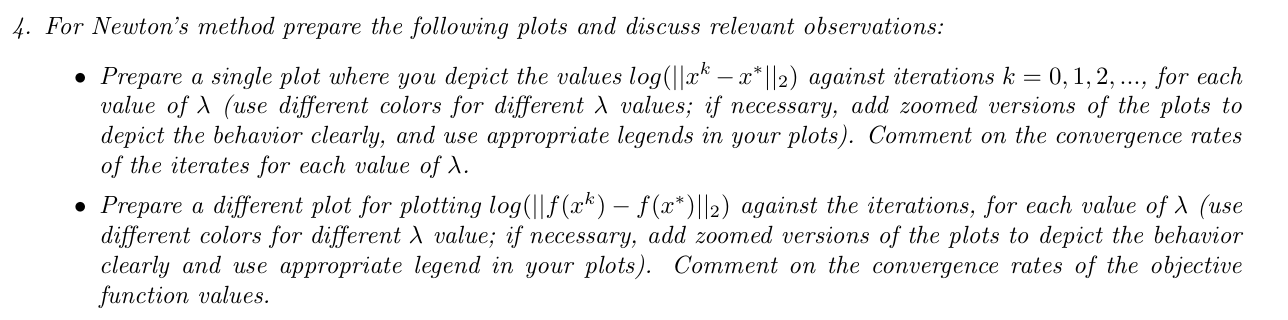

<ipython-input-35-790a8b9a66de>:12: RuntimeWarning: divide by zero encountered in log
  norms = [np.log(norm(xk-mnizer)) for xk in xks]


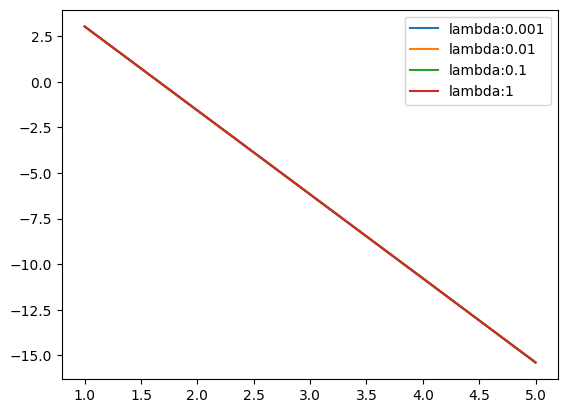

In [35]:
#for newtons methods

# lambdaxksbfgs.append(xks)
# lambdaxksnewton.append(xks2)
# iterationcountlambdabfgs.append(count)
# iterationcountlambdanewton.append(count2)
i=0
for lamda in lds:
  xks = lambdaxksnewton[i]
  mnizer = xks[-1]
  iteration = iterationcountlambdanewton[i]
  norms = [np.log(norm(xk-mnizer)) for xk in xks]
  iterations = [i+1 for i in range(iteration+1)]
  plt.plot(iterations, norms, label = f'lambda:{lamda}')
  i+=1
plt.legend()
plt.show()

<ipython-input-36-285e634a5def>:6: RuntimeWarning: divide by zero encountered in log
  norms = [np.log(abs(fx(mnizer, lamda)-fx(xk, lamda))) for xk in xks]


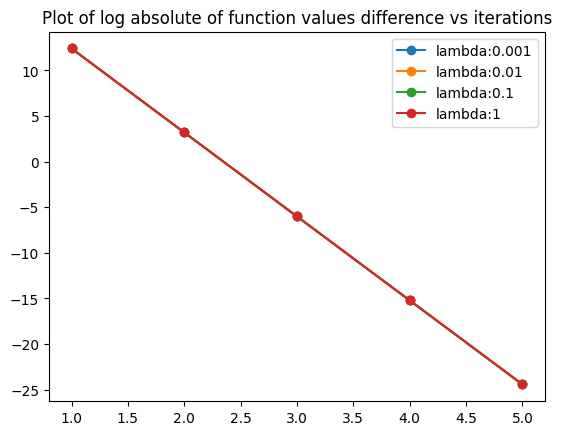

In [36]:
i=0
for lamda in lds:
  xks = lambdaxksnewton[i]
  mnizer = xks[-1]
  iteration = iterationcountlambdanewton[i]
  norms = [np.log(abs(fx(mnizer, lamda)-fx(xk, lamda))) for xk in xks]
  iterations = [i+1 for i in range(iteration+1)]
  plt.plot(iterations, norms, label = f'lambda:{lamda}', marker = 'o')
  i+=1
  plt.title("Plot of log absolute of function values difference vs iterations")
plt.legend()
plt.show()

All of them converge equally on the different values of $λ$, with iterations also being same (5) .

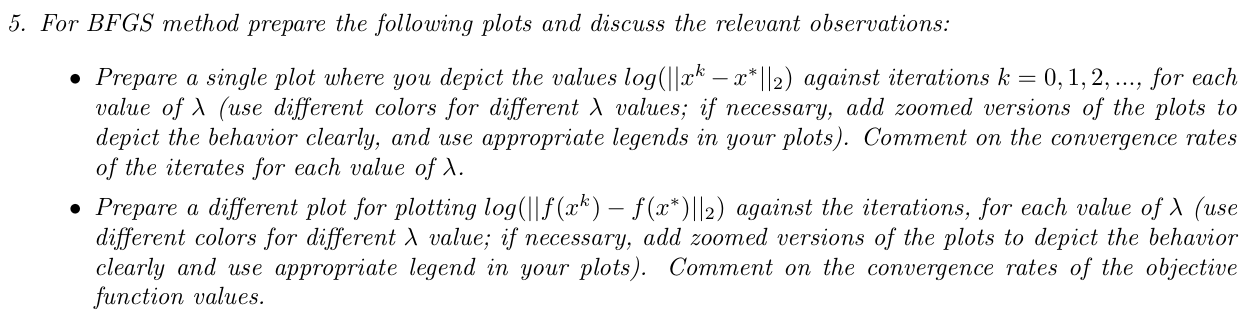

<ipython-input-37-ad33c9517977>:12: RuntimeWarning: divide by zero encountered in log
  norms = [np.log(norm(xk-mnizer)) for xk in xks]


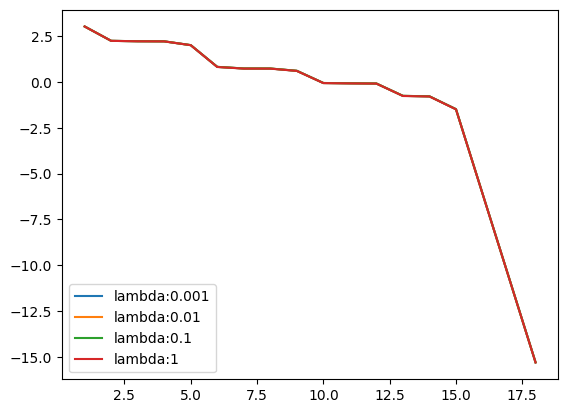

In [37]:
#for bfgs methods

# lambdaxksbfgs.append(xks)
# lambdaxksnewton.append(xks2)
# iterationcountlambdabfgs.append(count)
# iterationcountlambdanewton.append(count2)
i=0
for lamda in lds:
  xks = lambdaxksbfgs[i]
  mnizer = xks[-1]
  iteration = iterationcountlambdabfgs[i]
  norms = [np.log(norm(xk-mnizer)) for xk in xks]
  iterations = [i+1 for i in range(iteration+1)]
  plt.plot(iterations, norms, label = f'lambda:{lamda}')
  i+=1
plt.legend()
plt.show()

<ipython-input-38-46ea95aefde5>:6: RuntimeWarning: divide by zero encountered in log
  norms = [np.log(abs(fx(mnizer, lamda)-fx(xk, lamda))) for xk in xks]


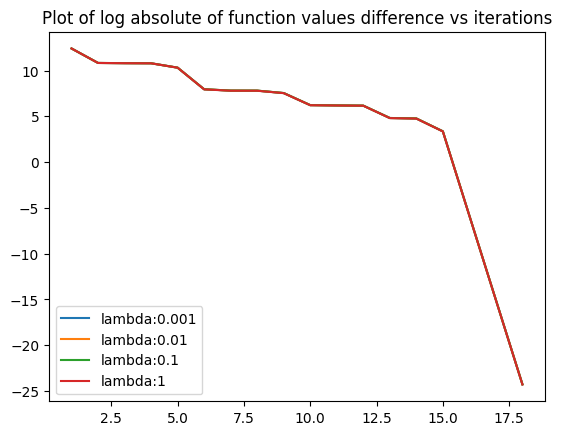

In [38]:
i=0
for lamda in lds:
  xks = lambdaxksbfgs[i]
  mnizer = xks[-1]
  iteration = iterationcountlambdabfgs[i]
  norms = [np.log(abs(fx(mnizer, lamda)-fx(xk, lamda))) for xk in xks]
  iterations = [i+1 for i in range(iteration+1)]
  plt.plot(iterations, norms, label = f'lambda:{lamda}')
  i+=1
  plt.title("Plot of log absolute of function values difference vs iterations")
plt.legend()
plt.show()

All of them converge equally on the different values of $λ$, with iterations also being same (18) .

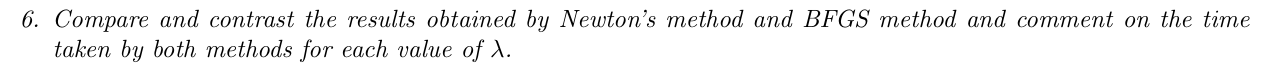

In [39]:
i = 0
for lamda in lds:
  print(f"Time taken by Newton for lambda: {lamda} is: {timetakennewton[i]}")
  i+=1

Time taken by Newton for lambda: 0.001 is: 0.0051403045654296875
Time taken by Newton for lambda: 0.01 is: 0.002033233642578125
Time taken by Newton for lambda: 0.1 is: 0.002042531967163086
Time taken by Newton for lambda: 1 is: 0.0020563602447509766


In [40]:
i = 0
for lamda in lds:
  print(f"Time taken by BFGS for lambda: {lamda} is: {timetakenbfgs[i]}")
  i+=1

Time taken by BFGS for lambda: 0.001 is: 0.02329730987548828
Time taken by BFGS for lambda: 0.01 is: 0.031974077224731445
Time taken by BFGS for lambda: 0.1 is: 0.022150516510009766
Time taken by BFGS for lambda: 1 is: 0.022152423858642578


As we can observe for all lambdas, the Newton is faster from BFGS, approximately 10 times faster. Also the time for newton is improved by regularization